In [ ]:
#| default_exp langmodels

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import string
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
with open('./names.txt') as f:
    names = f.read().splitlines()

Total number of names

In [ ]:
len(names)

32033

Problem with bigrams is that we were only looking the previous character to predict the next character, the more characters we look back, the bigger the matrix gets, with 2 characters then 27**2 sized matrix.

Instead we use this:


# Paper:

## A Neural Probabilistic Language Model: [paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In the paper, they've 17000 words in the vocabulary and for each word they assign a feature vector of dimension (30,). So all the 17000 words are embedded into a 30-dimensional space.

Initially the feature vectors are random and on training the feature vectors are updated...words with similar meanings are closer to each other in the vector space and converse is true.

Modelling approach: maximize log likelihood.

### Model Generalization: example (from the paper):

In the training set we might have a sentence like "the cat is walking in the bedroom", "the dog is running in a room". 

Due to the feature vectors, (a,the), (cat,dog), (room,bedroom), (is,was), (running,walking) might be closer together in the embedding space.

This allows the model to predict stuff like "the dog is walking in a ________" -> bedroom, "a cat is running the the _______" -> room


### Diagram

input: 3 previous words, output: 4th word. For each word there's a one-hot index vector, and then there's the embedding vector 17000X30. So a dot product will result in the feature vector of that word.

```python
# with 10 words vocab and 3-dimensional embedding feature vector
x = torch.tensor([0,0,1,0,0,0,0,0,0,0]) # word index vector
y = torch.randn(10,3) # embedding vector
y[2,:], x.float() @ y

>>> (tensor([1.2606, 0.1792, 0.1153]), tensor([1.2606, 0.1792, 0.1153]))
```

so for the 3 words, 90 neurons: 30 from each word

hidden layer: size is the hyperparameter, fully connected to the 90 input neurons with tanh activation.

output layer: (17000,) layer with softmax which will give probability distribution for the next word in sequence. with argmax(output), we can get the index of the next word. 



![model](https://i.imgur.com/Yjag5Ud.png)


# Creating the Dataset

In [ ]:
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
vocab = ['.'] + list(string.ascii_lowercase)
s_i = {s:i for i,s in enumerate(vocab)}
i_s = {i:s for s,i in s_i.items()}
print(s_i,'\n')
print(i_s)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26} 

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [ ]:
block_size = 3 # length of context: no. of characters we use to predict the next

X, Y = [], []
for w in names[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = s_i[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(i_s[i] for i in context), '-->', i_s[ix])
        context = context[1:] + [ix] # crop and append, like a rolling window
        
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .
olivia
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
ava
... --> a
..a --> v
.av --> a
ava --> .
isabella
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
sophia
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

Since we are working with characters and not words 2 dimensions will be enough to represent 27 characters (26 Alphabets and a `.` character at the end). However in the paper they have 30 dimensions to represent 17000 words of vocabulary.

In [ ]:
# embedding look-up table C: 27 vocab -> 2-dimensional space

C = torch.randn((27,2))
C.shape

torch.Size([27, 2])

In PyTorch there are many ways get the embeddings using the look-up table `C`. First method is just to use index range from 0-27 inclusive and get the embedding for that character which will be 2 dimensional in this case `C[5]`. Second method is to convert the index into one hot encoding vectors which can then later be use to pluck out the embeddings `F.one_hot(torch.tensor(5), num_classes=27).float() @ C`. 

Note @ operator in PyTorch represent matrix multiplication operation

In [ ]:
C[5], F.one_hot(torch.tensor(5), num_classes=27).float() @ C

(tensor([-0.2063,  0.5881]), tensor([-0.2063,  0.5881]))

Also we could use a vector to pluck out multiple embeddings in a single call. We could also pluck out embedding of multiple characters at the same time using `C[torch.tensor([5,6,7,7,7])]` 

In [ ]:
C[torch.tensor([5,6,7])] # index with a vector

tensor([[-0.2063,  0.5881],
        [-0.1750, -0.1636],
        [ 0.1559,  0.7583]])

Using the same above token we could pass the 3 characters tensors we built when creating the dataset to index with a matrix, hence for each of the 3 chars in the context, we get their respective feature vectors

In [ ]:
C[X[1]]

tensor([[ 0.8973, -0.7494],
        [ 0.8973, -0.7494],
        [-0.2063,  0.5881]])

Also we could just simply pass the whole feature set in this case these will be 3 characters and pluck out their respective feature vectors. 

In [ ]:
C[X].shape

torch.Size([32, 3, 2])

Right now we are only taking 5 names at the moment so we are only taking 32 examples. Each example contains 3 characters for the training and model job is to predict out the 4th character.

In [ ]:
X.shape

torch.Size([32, 3])

Recall again at this point that X is a tensor with (32, 3) shape. There are total of 32 examples at the moment and at each example there are 3 characters. So `X[13,2]` means take out the value at index 2 of example at 13 index, which will give us a number range from 0-27 (26 Alphabets and a single `.` character at the end of each name)

Now when we run `C[X]` it will get all the embeddings for each example in our dataset, once we get all the embeddings we can then use index `[13,2]` to access embedding at that particular index

Similarly we could just simply use the index of the character range from 0-27 to directly pluck out the embeddings from the C look-up table

In [ ]:
X[13,2], C[X][13,2], C[1]

(tensor(1), tensor([-1.1704,  1.9040]), tensor([-1.1704,  1.9040]))

We get all the embeddings for our characters in the dataset in the variable `emb`

In [ ]:
emb = C[X]

Construction of hidden layer

In [ ]:
hidden_dim = 100

W1 = torch.randn((6,hidden_dim))
b1 = torch.randn(hidden_dim)

### We cant do

```python
emb @ W1 + b1 # since the embeddings are stacked as [3,2]
```

##### transforming [32,3,2] -> [32,6]

multiple methods:

- CONCAT: issue: cant generalize if 5 dimensional then we've to do till 4.
```python
    print('cat:',emb[:,0,:].shape, emb[:,1,:].shape, emb[:,2,:].shape)
    print(torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]], 1).shape)
    >>> cat: torch.Size([32, 2]) torch.Size([32, 2]) torch.Size([32, 2])
    >>> torch.Size([32, 6])
```

- UNBIND: removes a tensor dimension, returns a list.
```python
    print('cat, unbind:', torch.cat(torch.unbind(emb, 1), 1).shape)
    >>> cat, unbind: torch.Size([32, 6])
```

- VIEW: reshape
```python
    print('view:',emb.view(32,6).shape)
    >>> view: torch.Size([32, 6])
```

View is the best since it doesn't create a new tensor unlike cat and unbind and tensor representation changes internally.

also, instead of doing `.view(32,6)`, we can do `.view(emb.shape[0],6)` or `.view(-1,6)`

In [ ]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h.shape

torch.Size([32, 100])

We are taking two hidden layers in the model architecture

In [ ]:
W2 = torch.randn((hidden_dim, 27))
b2 = torch.randn(27)

logits are the probabilities of given 32 characters what character to be followed next most likely out of 27 characters

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

torch.Size([32, 27])

In [ ]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape, prob.sum(1)

(torch.Size([32, 27]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000]))

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.0337)

Complete Model Architecture

In [ ]:
# with a generator and seed
seed = 2147483647
g = torch.Generator().manual_seed(seed)

hidden_dim = 100
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]

In [ ]:
# num parameters
sum(p.nelement() for p in parameters)

3481

### Calculating Loss
 

```python
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
```
reason for not using the above all the time:
- lot of intermediate tensors
- longer and complex backprop due to more tensors
- numerically not so well behaved, see:

```python
counts = torch.tensor([-2,-3,0,5]).exp()
prob = counts / counts.sum()
print(counts, prob)
counts = torch.tensor([-100,-3,0,5]).exp()
prob = counts / counts.sum()
print(counts, prob)
counts = torch.tensor([-100,-3,0,100]).exp()
prob = counts / counts.sum()
print(counts, prob)
>>> tensor([1.3534e-01, 4.9787e-02, 1.0000e+00, 1.4841e+02]) tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])
>>> tensor([3.7835e-44, 4.9787e-02, 1.0000e+00, 1.4841e+02]) tensor([0.0000e+00, 3.3311e-04, 6.6906e-03, 9.9298e-01])
>>> tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf]) tensor([0., 0., 0., nan])
```

- also any offset will produce same probabilities due to exp()

```python
counts = torch.tensor([-2,-3,0,5]).exp()
prob = counts / counts.sum()
print(prob)
counts = (torch.tensor([-2,-3,0,5]) - 10).exp() # -10 offset
prob = counts / counts.sum()
print(prob)
>>> tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])
>>> tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])
```

- what `F.cross_entropy(preds,trues)` does is subtracts the largest value in the tensor, which gives usable probabilities

Before training start we need to set all the parameters' requires_grad to true to tell PyTorch to automatically compute gradients for each parameter

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
# forward pass:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697, grad_fn=<NllLossBackward0>)

In [ ]:
# backward pass
for p in parameters:
    p.grad = None
    
loss.backward()

# optimize
for p in parameters:
    p.data += -0.1 * p.grad

### Training Loop

Here we have only 32 examples, hence we're technically overfitting a batch of 32

If we use all names we'll have 200k+ examples and we'll be forward and backward passing through all of them at once which takes a lot of compute time

Instead what we do is use mini-batches of data -- randomly selected and compute passes on those

In [ ]:
seed = 2147483647
g = torch.Generator().manual_seed(seed)

hidden_dim = 100
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad = True

epochs = 10
lr = 0.1

losses = []

for epoch in range(epochs):
    
    # forward pass
    
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Y)
    losses.append(loss)
    
    for p in parameters:
        p.grad = None
        
    # calc gradients
    loss.backward()
    
    # optimize
    for p in parameters:
        p.data += -lr * p.grad
        
    print(f"loss at epoch {epoch+1}:\t {loss.item()}")

loss at epoch 1:	 17.769712448120117
loss at epoch 2:	 13.656402587890625
loss at epoch 3:	 11.298768997192383
loss at epoch 4:	 9.452457427978516
loss at epoch 5:	 7.984262466430664
loss at epoch 6:	 6.891321182250977
loss at epoch 7:	 6.1000142097473145
loss at epoch 8:	 5.452036380767822
loss at epoch 9:	 4.8981523513793945
loss at epoch 10:	 4.414663791656494


Now using all the examples 

In [ ]:
# dataset

block_size = 3 # length of context: no. of characters we use to predict the next

X, Y = [], []
for w in names:
    context = [0] * block_size
    for ch in w + '.':
        ix = s_i[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append, like a rolling window
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
C = torch.randn((27,2))

In [ ]:
seed = 2147483647
hidden_dim = 100
g = torch.Generator().manual_seed(seed)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True
    
# ------------

epochs = 100
lr = 0.1
batch_size = 32
losses = []

for epoch in range(1,epochs+1):
    
    # mini-batch creation
    ix = torch.randint(0,X.shape[0], (batch_size,))
    
    # forward pass
    
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Y[ix])
    losses.append(loss.item())
    
    for p in parameters:
        p.grad = None
        
    # calc gradients
    loss.backward()
    
    # optimize
    for p in parameters:
        p.data += -lr * p.grad
        
    if epoch%(epochs//10) == 0:
        print(f"loss at epoch {epoch}:\t {loss.item()}")
        
# --- total loss
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print("\nTotal Loss:",loss.item())

loss at epoch 10:	 11.600504875183105
loss at epoch 20:	 10.521777153015137
loss at epoch 30:	 5.835473537445068
loss at epoch 40:	 5.3462066650390625
loss at epoch 50:	 6.919842720031738
loss at epoch 60:	 4.665844440460205
loss at epoch 70:	 3.684293270111084
loss at epoch 80:	 3.533886671066284
loss at epoch 90:	 4.2809247970581055
loss at epoch 100:	 3.3377153873443604

Total Loss: 3.74735426902771


Plotting the loss with epochs, to check how loss decrease when we pass mini-batches. You can see the volatility between losses as mini-batch doesn't represent the complete dataset

[<matplotlib.lines.Line2D>]

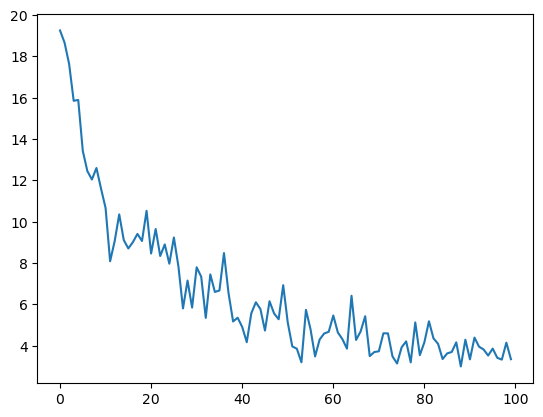

In [ ]:
plt.plot(losses)

Since now we have been using 0.1 as our learning rate but there is way to determine the best learning rate for our problem

In [ ]:
lr_exp = torch.linspace(-3,0,1000)
lrs = 10**lr_exp # exponential spacing between LRs

In [ ]:
g = torch.Generator().manual_seed(seed)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True
    
# ------------

epochs = 1000
batch_size = 32
losses = []

for epoch in range(1,epochs+1):
    
    # mini-batch creation
    ix = torch.randint(0,X.shape[0], (batch_size,))
    
    # forward pass
    
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Y[ix])
    losses.append(loss.item())
    
    for p in parameters:
        p.grad = None
        
    # calc gradients
    loss.backward()
    
    # getting lr
    lr = lrs[epoch-1]
    
    # optimize
    for p in parameters:
        p.data += -lr * p.grad
        
    if epoch%(epochs//10) == 0:
        print(f"loss at epoch {epoch}:\t {loss.item()}")
        
# --- total loss
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print("\nTotal Loss:",loss.item())

loss at epoch 100:	 16.775936126708984
loss at epoch 200:	 14.972878456115723
loss at epoch 300:	 11.613161087036133
loss at epoch 400:	 6.739404678344727
loss at epoch 500:	 6.509151458740234
loss at epoch 600:	 3.7060327529907227
loss at epoch 700:	 2.9348864555358887
loss at epoch 800:	 4.311702728271484
loss at epoch 900:	 4.990762233734131
loss at epoch 1000:	 7.118990898132324

Total Loss: 7.572385787963867


[<matplotlib.lines.Line2D>]

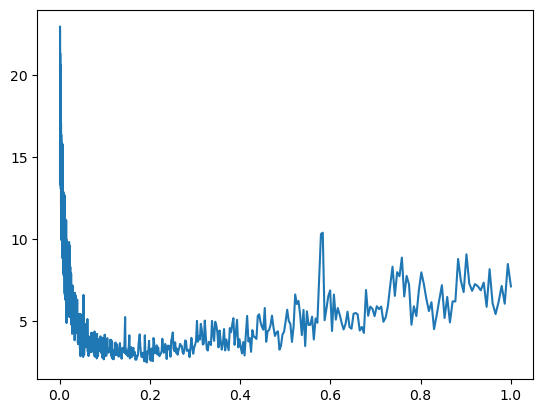

In [ ]:
plt.plot(lrs, losses)

[<matplotlib.lines.Line2D>]

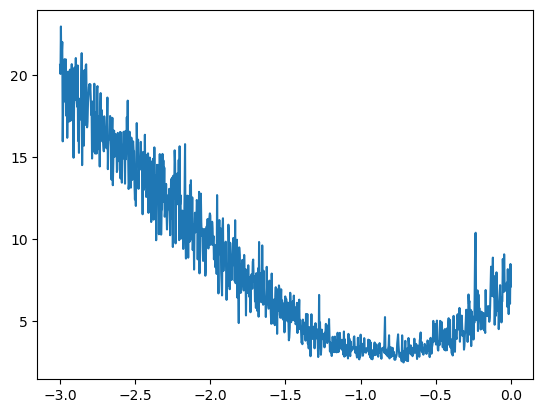

In [ ]:
plt.plot(lr_exp, losses)

From the above graphs, we notice that the losses explode at some LR value after 10**-1, hence lr=0.1 is pretty decent

**Let's train for 30000 epochs with lr decay after 20k and 28k epochs**

In [ ]:
g = torch.Generator().manual_seed(seed)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True
    
# ------------

epochs = 30000
lr = 0.1
batch_size = 32
losses = []

for epoch in range(1,epochs+1):
    
    # mini-batch creation
    ix = torch.randint(0,X.shape[0], (batch_size,))
    
    # forward pass
    
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Y[ix])
    losses.append(loss.item())
    
    for p in parameters:
        p.grad = None
        
    # calc gradients
    loss.backward()
    
    # update lr
    if epoch > 20000:
        lr = 0.01
    elif epoch > 28000:
        lr = 0.001
    
    # optimize
    for p in parameters:
        p.data += -lr * p.grad
        
    if epoch%3000 == 0:
        print(f"loss at epoch {epoch}:\t {loss.item()}")
        
# --- total loss
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print("\nTotal Loss:",loss.item())

loss at epoch 3000:	 2.6296911239624023
loss at epoch 6000:	 2.74481201171875
loss at epoch 9000:	 2.112273693084717
loss at epoch 12000:	 2.591141700744629
loss at epoch 15000:	 2.684185028076172
loss at epoch 18000:	 2.3270766735076904
loss at epoch 21000:	 2.4287893772125244
loss at epoch 24000:	 2.7208263874053955
loss at epoch 27000:	 2.207639455795288
loss at epoch 30000:	 2.339667558670044

Total Loss: 2.3456742763519287


[<matplotlib.lines.Line2D>]

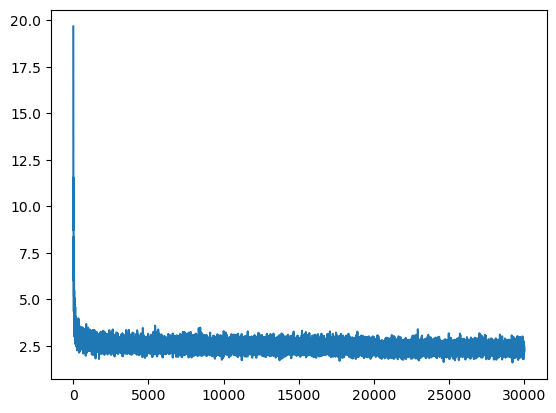

In [ ]:
plt.plot(losses)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()